In [22]:
#pip install --user sweetviz

In [24]:
#pip install --user ppscore

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sweetviz
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load data, merge into one df, create target variable

In [3]:
#data from: https://demographics.texas.gov/Data/Decennial/2010/ using 2a. all county scraper notebook
stats_df = pd.read_csv("5. County Stats.csv")

# data from: https://www.dshs.texas.gov/coronavirus/additionaldata/
cases_df = pd.read_excel("6. Texas COVID-19 Case Count Data by County.xlsx") 
deaths_df = pd.read_excel("7. Texas COVID-19 Fatality Count Data by County.xlsx")

In [4]:
#strip country str from County column in stats_df so we can merge with cases_df
def cut_county_name(s):
    return s[:-7]

stats_df["County"] = stats_df["County"].map(cut_county_name)

common = stats_df.merge(cases_df[:254],how = "inner", left_on = "County", right_on = "County Name")

common.drop(common.iloc[:, 24:150], inplace = True, axis = 1) #dropping unused case dates

common["County"].describe() #checking for duplicates

count        254
unique       254
top       Donley
freq           1
Name: County, dtype: object

### create 7 day case change column, normalize it, clean it, bin it, and finally create binary target

<AxesSubplot:ylabel='Frequency'>

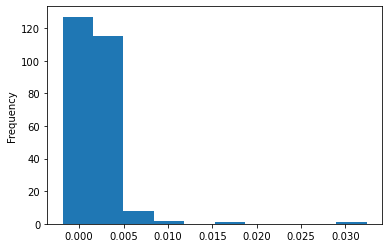

In [5]:
common["7 day case change"] = common["Cases 07-28"] - common["Cases 07-21"] 

common["7 day normalized"] = common["7 day case change"] / common["Total Population"]

common['7 day normalized'].plot(kind='hist')

In [6]:
common['7 day normalized'] = pd.to_numeric(common['7 day normalized'])

common['7 day normalized'].describe()

count    254.000000
mean       0.002075
std        0.002759
min       -0.001881
25%        0.000823
50%        0.001538
75%        0.002447
max        0.032421
Name: 7 day normalized, dtype: float64

In [7]:
# need to replace negative numbers with 0
mask = common['7 day normalized'] < 0
common[mask]

,County,Total Population,Total Families,Total Households,Population in Families,Population in Households,Family: Under Eightteen years,House: Under Eightteen years,Family: Eighteen years and over,House: Eighteen years and over,Average Family Size,Average Household Size,Family: Under Eightteen years.1,House: Under Eightteen years.1,Family: Eighteen years and over.1,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian/Other Pacific Islander alone,Some Other Race alone,Two or More Races,Hispanic or Latino (Any race),"White alone, not Hispanic",Cases 07-09,Cases 07-10,Cases 07-11,Cases 07-12,Cases 07-13,Cases 07-14,Cases 07-15*,Cases 07-16,Cases 07-17**,Cases 07-18,Cases 07-19,Cases 07-20,Cases 07-21,Cases 07-22,Cases 07-23,Cases 07-24,Cases 07-25,Cases 07-26,Cases 07-27,Cases 07-28,7 day case change,7 day normalized
126,Jones,20202.0,4236.0,6034.0,12769.0,15195.0,3660.0,3734.0,9109.0,11461.0,3.01,2.52,0.86,0.62,2.15,5245.0,216.0,37.0,22.0,0.0,428.0,86.0,1032.0,4686.0,607.0,604.0,604.0,604.0,604.0,607.0,609.0,608.0,639.0,641.0,641.0,641.0,659.0,653.0,652.0,631.0,621.0,621.0,621.0,621.0,-38.0,-0.001881
177,Nueces,340223.0,85270.0,124587.0,275530.0,334431.0,86498.0,88017.0,189032.0,246414.0,3.23,2.68,1.01,0.71,2.22,103463.0,5142.0,814.0,1883.0,89.0,10738.0,2458.0,65886.0,50565.0,4917.0,5260.0,5672.0,5965.0,6174.0,6427.0,7032.0,7532.0,7861.0,8171.0,8407.0,8579.0,8816.0,9105.0,9607.0,9961.0,7994.0,8127.0,8178.0,8342.0,-474.0,-0.001393
201,Sabine,10834.0,3235.0,4738.0,8910.0,10755.0,2096.0,2120.0,6814.0,8635.0,2.75,2.27,0.65,0.45,2.11,4316.0,336.0,20.0,13.0,0.0,29.0,30.0,96.0,4255.0,28.0,29.0,31.0,31.0,33.0,34.0,34.0,34.0,35.0,35.0,35.0,36.0,39.0,39.0,39.0,40.0,36.0,37.0,37.0,37.0,-2.0,-0.000185
208,Shackelford,3378.0,937.0,1367.0,2797.0,3342.0,811.0,828.0,1986.0,2514.0,2.99,2.44,0.87,0.61,2.12,1308.0,27.0,22.0,0.0,0.0,31.0,12.0,85.0,1262.0,6.0,8.0,8.0,8.0,8.0,9.0,9.0,10.0,11.0,13.0,13.0,13.0,18.0,17.0,15.0,16.0,16.0,16.0,16.0,17.0,-1.0,-0.000296


In [8]:
def replace_w_0(s):
    if s < 0:
        return 0
    else:
        return s
    
common['7 day normalized'] = common['7 day normalized'].map(replace_w_0)
mask = common['7 day normalized'] < 0
common[mask]

,County,Total Population,Total Families,Total Households,Population in Families,Population in Households,Family: Under Eightteen years,House: Under Eightteen years,Family: Eighteen years and over,House: Eighteen years and over,Average Family Size,Average Household Size,Family: Under Eightteen years.1,House: Under Eightteen years.1,Family: Eighteen years and over.1,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian/Other Pacific Islander alone,Some Other Race alone,Two or More Races,Hispanic or Latino (Any race),"White alone, not Hispanic",Cases 07-09,Cases 07-10,Cases 07-11,Cases 07-12,Cases 07-13,Cases 07-14,Cases 07-15*,Cases 07-16,Cases 07-17**,Cases 07-18,Cases 07-19,Cases 07-20,Cases 07-21,Cases 07-22,Cases 07-23,Cases 07-24,Cases 07-25,Cases 07-26,Cases 07-27,Cases 07-28,7 day case change,7 day normalized


In [9]:
bin_labels_5 = ['very low', 'low', 'medium', 'high', 'very high']
common["5 bins"] = pd.qcut(common['7 day normalized'], q=5, labels = bin_labels_5)

In [10]:
common['5 bins'].value_counts()

very high    51
high         51
low          51
very low     51
medium       50
Name: 5 bins, dtype: int64

In [11]:
def create_binary_target(s):
    if s == 'very high':
        return 1
    elif s == 'high':
        return 1
    else:
        return 0
    
common["target"] = common["5 bins"].map(create_binary_target) 

## EDA

In [12]:
common = common.set_index("County")

In [13]:
X = common.iloc[:, :23]

In [14]:
y = common.iloc[:, -1]

In [15]:
df = X.join(y)

In [16]:
train, test = train_test_split(df, test_size=0.33, random_state=42)

In [19]:
my_report = sweetviz.compare([train, "Train"], [test, "Test"], "target")


                                   |                         | [  0%]   00:00  -> (? left)
Summarizing dataframe:             |                         | [  0%]   00:00  -> (? left)
:TARGET::                          |▊                    | [  4%]   00:00  -> (00:00 left)
:TARGET::                          |█▋                   | [  8%]   00:00  -> (00:05 left)
:Total Population:                 |█▋                   | [  8%]   00:00  -> (00:05 left)
:Total Population:                 |██▌                  | [ 12%]   00:01  -> (00:10 left)
:Total Families:                   |██▌                  | [ 12%]   00:01  -> (00:10 left)
:Total Families:                   |███▎                 | [ 16%]   00:02  -> (00:14 left)
:Total Households:                 |███▎                 | [ 16%]   00:02  -> (00:14 left)
:Total Households:                 |████▏                | [ 20%]   00:03  -> (00:15 left)
:Population in Families:           |████▏                | [ 20%]   00:03  -> (00:15 left

Creating Associations graph... DONE!


In [20]:
my_report.show_html("4a. EDA Report.html") # Not providing a filename will default to SWEETVIZ_REPORT.html

Report 4a. EDA Report.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


<AxesSubplot:xlabel='x', ylabel='y'>

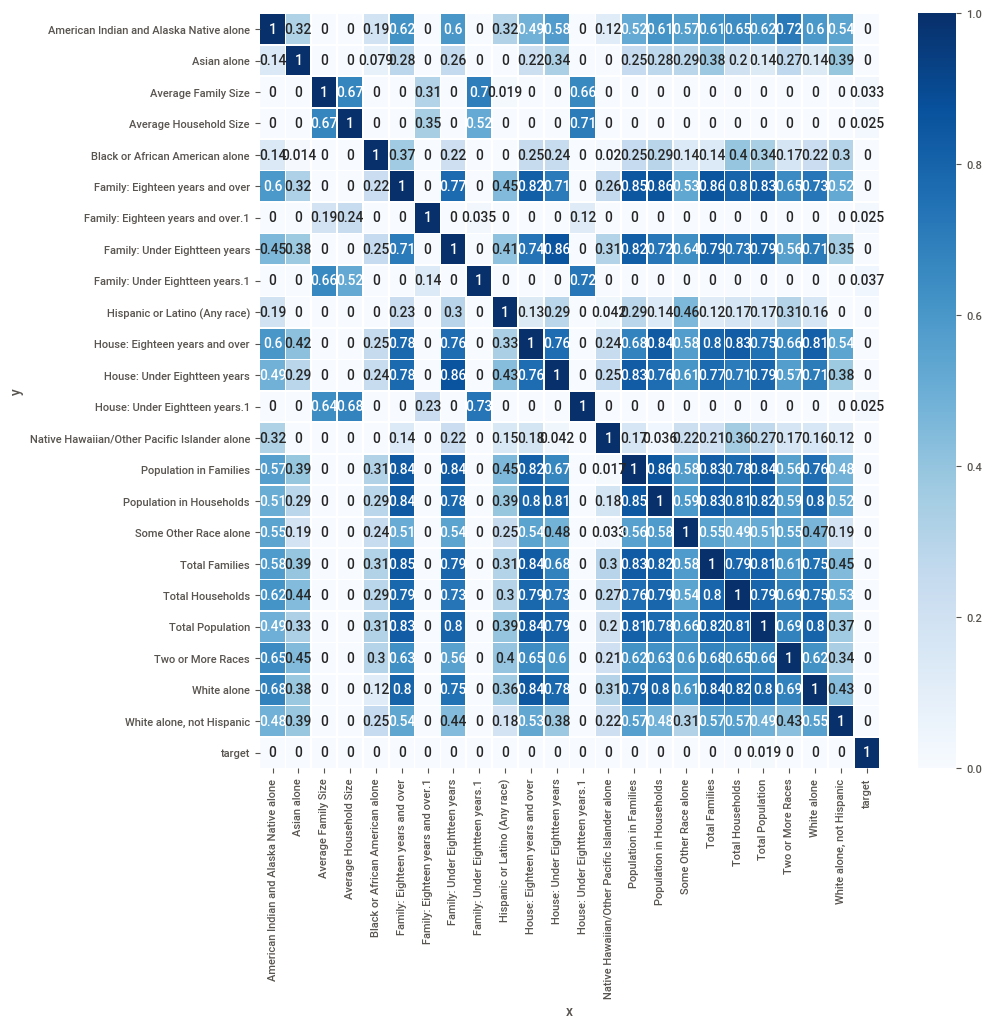

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, ax = ax)

<AxesSubplot:xlabel='Family: Under Eightteen years.1', ylabel='target'>

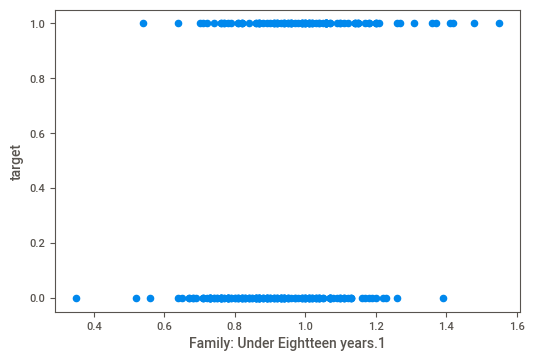

In [38]:
df.plot.scatter('Family: Under Eightteen years.1', "target")